 <center> <h1> <b> Neural Networks </b> </h1> </center>



**Part - (1): Develop a neural network based classification network from scratch:**

This programming assignment uses MNIST digit dataset. It consists of large collection of handwritten digits from 0 to 9. These images are formated as 28x28 pixel gray scale images. The objective of this programming assignment is to design a neural network architecture that takes input as 28x28 image (or 784 dimensional vector) as input and predicts the digit information in it. Although there are diffrent varieties of neural network architecture to solve this task, this programming assignment uses only the feed forward network.  

1. **Load MNIST data and create train, test splits**
   - The MNIST dataset consists of around 70,000 images. Divide the dataset into two segments: training and testing. Allocate 60,000 images for training and 10,000 images for testing.
   - Code for downloading the data and creating train-test splits is provided.

2. **Design a simple classification network**
   - Let us use a three-layer feed-forward neural network. Use 512 nodes in the hidden layers and 10 nodes in the output layer. The output **y** from the input **x** is computed as follows:
   
     $$ \textbf{y} = h(\textbf{W}_{3}g(\textbf{W}_{2}g(\textbf{W}_{1}\textbf{x}))) $$
     
     where $\textbf{W}_{1} \in \mathbb{R}^{512 \times 768}$, $\textbf{W}_{2} \in \mathbb{R}^{512 \times 512}$, $\textbf{W}_{3} \in \mathbb{R}^{10 \times 512}$ are the parameters of the network. **g(.)** is the hidden layer activation function. **h(.)** is the output layer activation function.
     
   - Consider **g(.)** as ReLU activation function. Softmax activation function should be used at the last layer **h(.)**, to get the posterior probability of the classes.

3. **Training classification network**
   - Flatten the 28x28 images to arrive at a 784-dimensional vector.
   - Randomly initialize the parameters of the network, $\textbf{W}_{1} \in \mathbb{R}^{768 \times 512}$, $\textbf{W}_{2} \in \mathbb{R}^{512 \times 512}$, $\textbf{W}_{3} \in \mathbb{R}^{512 \times 10}$.
   - Feed forward the batch of input vectors to get the posterior probability of classes.
   - Compute the loss between the estimated posterior probabilities and the true targets.
   - Update the parameters of the network to minimize the loss function.
     - Backpropagate the loss function to get the gradients.
     - You can use stochastic gradient descent (SGD) optimization algorithm to update the parameters.
     - Cleverly set the hyperparameters involved in this optimization process.

4. **Evaluate the performance of classification network**
   - Feed-forward the MNIST data through the trained classification network to get class posteriors.
   - Assign the input to the class having the maximum posterior probability.
   - Compute the loss and accuracy.
   - Report your observations.

In [1]:
#All imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

In [2]:
##################################################
#Load MNIST data.
##################################################
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

#Training data
mnist_traindata = mnist_trainset.data.numpy()
mnist_trainlabel = mnist_trainset.targets.numpy()
print("Training data",mnist_traindata.shape)
print("Training labels",mnist_trainlabel.shape)

#Testing data
mnist_testdata = mnist_testset.data.numpy()
mnist_testlabel = mnist_testset.targets.numpy()
print("Testing data",mnist_testdata.shape)
print("Testing labels",mnist_testlabel.shape)

Training data (60000, 28, 28)
Training labels (60000,)
Testing data (10000, 28, 28)
Testing labels (10000,)


In [3]:
##################################################
#Define the architecture
##################################################
def ReLu(inp):
    return np.maximum(inp, 0)

def gradReLu(inp):
    return (inp >= 0).astype(int)

def softmax(inp):
    exp_inp = np.exp(inp)
    return exp_inp / np.sum(exp_inp, axis=1, keepdims=True)

def fwdPropagate(inputs, weights):
    W1, W2, W3 = weights
    z1 = np.dot(inputs, W1.T)
    h1 = ReLu(z1)
    z2 = np.dot(h1, W2.T)
    h2 = ReLu(z2)
    z3 = np.dot(h2, W3.T)
    output = softmax(z3)
    activations = [z1, h1, z2, h2, z3, output]
    return activations

# Complete the below function to compute the gradients
def computeGradients(inputs, targets, weights, activations):
    #Inputs: input data, targets, parameters of netwrok, intermediate activations
    W1, W2, W3 = weights
    z1, h1, z2, h2, z3, output = activations

    #Compute the derivative of loss at parameters
    del3 = output - targets
    dj_dw3 = del3.T @ h2

    del2 = (del3 @ W3) * gradReLu(z2)
    dj_dw2 = del2.T @ h1

    del1 = (del2 @ W2) * gradReLu(z1)
    dj_dw1 = del1.T @ inputs


    #Return the gradients
    return [dj_dw1, dj_dw2, dj_dw3]


# Complete the below function to update the parameters using the above computed gradients
def applyGradients(weights, gradients, learning_rate):
    #Inputs: weights, gradients, and learning rate
    W1, W2, W3 = weights
    dj_dw1, dj_dw2, dj_dw3 = gradients

    #Return the updated parameters
    W1 -= learning_rate * dj_dw1
    W2 -= learning_rate * dj_dw2
    W3 -= learning_rate * dj_dw3

    return [W1, W2, W3]


def backPropagate(inputs, targets, weights, activations, learning_rate):
    #Inputs: input data, targets, parameters of network, intermediate activations, learning rate of optimization algorithm
    # activations = fwdPropagate(inputs, weights)
    #Compute the gradients
    gradients = computeGradients(inputs, targets, weights, activations)
    #Update the paramters using gradients
    weights = applyGradients(weights, gradients, learning_rate)
    #Return the updated parameters
    return weights


In [4]:
##################################################
#Train the network
##################################################
def training(inputs, targets_idx, batch_size=128, epochs=20, train_val_split=0.9, learning_rate=0.0002):
    Inputs = np.zeros((len(inputs), inputs.shape[1]**2))
    for i in range(len(inputs)):
        Inputs[i] = inputs[i].flatten()

    # Set the hyperparameters
    hidden_units = 512
    n_classes = 10
    n_samples = Inputs.shape[0]
    n_batches = n_samples // batch_size

    # Split the training data into two parts.
    # Use 90 percent of training data for training the network.
    # Remaining 10 percent as validation data
    split_index = int(train_val_split * len(Inputs))
    train_inputs, train_targets = Inputs[:split_index], targets_idx[:split_index]
    test_inputs, test_targets = Inputs[split_index:], targets_idx[split_index:]

    # Randomly initialize the weights
    input_size = Inputs.shape[1]
    W1 = np.random.randn(hidden_units, input_size) * 0.001
    W2 = np.random.randn(hidden_units, hidden_units) * 0.001
    W3 = np.random.randn(n_classes, hidden_units) * 0.001
    weights = [W1, W2, W3]

    # Iterate for epochs times
    for epoch in range(epochs):
        # Shuffle the training data
        shuffle_index = np.random.permutation(split_index)
        train_inputs_shuffled = train_inputs[shuffle_index]
        train_targets_shuffled = train_targets[shuffle_index]

        # Iterate through the batches of data
        for batch in range(n_batches):
            # Get the batch of data
            start = batch * batch_size
            end = start + batch_size
            batch_inputs = train_inputs_shuffled[start:end]
            batch_targets = train_targets_shuffled[start:end]

            # Forward propagation
            activations = fwdPropagate(batch_inputs, weights)

            # Backward propagation
            weights= backPropagate(batch_inputs, batch_targets, weights, activations, learning_rate)

        # Compute outputs on training data
        train_activations = fwdPropagate(train_inputs, weights)
        train_output = train_activations[-1]

        # Compute training accuracy and training error
        train_predictions = np.argmax(train_output, axis=1)
        train_accuracy = np.mean(train_predictions == np.argmax(train_targets, axis = 1))
        train_error = 1 - train_accuracy

        # Compute outputs on validation data
        test_activations = fwdPropagate(test_inputs, weights)
        test_output = test_activations[-1]

        # Compute validation accuracy and validation error
        test_predictions = np.argmax(test_output, axis=1)
        test_accuracy = np.mean(test_predictions == np.argmax(test_targets, axis = 1))
        test_error = 1 - test_accuracy

        # Print the statistics of training
        print(f"Epoch {epoch + 1}/{epochs}, Train Error: {train_error:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Error: {test_error:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Save the parameters of the network

# Call the training function to train the network
# training(inputs, targets_idx)

targets = np.zeros((len(mnist_trainlabel), 10))
for i in range(0, len(mnist_trainlabel)):
    targets[i][int(mnist_trainlabel[i])] = 1

training(mnist_traindata, targets)

Epoch 1/20, Train Error: 0.1257, Train Accuracy: 0.8743, Test Error: 0.1043, Test Accuracy: 0.8957
Epoch 2/20, Train Error: 0.0598, Train Accuracy: 0.9402, Test Error: 0.0515, Test Accuracy: 0.9485
Epoch 3/20, Train Error: 0.0431, Train Accuracy: 0.9569, Test Error: 0.0435, Test Accuracy: 0.9565
Epoch 4/20, Train Error: 0.0306, Train Accuracy: 0.9694, Test Error: 0.0345, Test Accuracy: 0.9655
Epoch 5/20, Train Error: 0.0257, Train Accuracy: 0.9743, Test Error: 0.0323, Test Accuracy: 0.9677
Epoch 6/20, Train Error: 0.0236, Train Accuracy: 0.9764, Test Error: 0.0297, Test Accuracy: 0.9703
Epoch 7/20, Train Error: 0.0207, Train Accuracy: 0.9793, Test Error: 0.0302, Test Accuracy: 0.9698
Epoch 8/20, Train Error: 0.0177, Train Accuracy: 0.9823, Test Error: 0.0288, Test Accuracy: 0.9712
Epoch 9/20, Train Error: 0.0151, Train Accuracy: 0.9849, Test Error: 0.0238, Test Accuracy: 0.9762
Epoch 10/20, Train Error: 0.0112, Train Accuracy: 0.9888, Test Error: 0.0227, Test Accuracy: 0.9773
Epoch 11/

**Report your observations**
1. **Consistent Improvement**: Both training and test accuracies show steady improvement over epochs, indicating effective learning and generalization.
2. **High Accuracy**: Achieved high test accuracy (around 97%) with ReLU activation function, indicating suitability for the task.
3. **Stability**: The model exhibits stability with minimal fluctuations in errors, suggesting robustness to variations in the dataset.

**Part - (2) : Understanding activation functions:** 
In this part you will learn to use different activation functions for the classification task and compare their performances.

- Train MNIST digit classification network with different activation functions i.e. Sigmoid, Tanh, ReLU, LeakyReLU etc. You can stick to stochastic gradient descent optimization algorithm for this part. 
- Report the accuray on MNIST test data for all the experiments. Write down your observations in the report.



In [5]:
##################################################
#Train the network with different activation functions
##################################################

def Sigmoid(x):
    return 1 / (1 + np.exp(-x))

def grad_Sigmoid(x):
    return Sigmoid(x) * (1 - Sigmoid(x))

def Tanh(x):
    return np.tanh(x)

def grad_Tanh(x):
    return 1 - np.tanh(x)**2

def LeakyReLu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def grad_LeakyReLu(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(inp):
    exp_inp = np.exp(inp)
    return exp_inp / np.sum(exp_inp, axis=1, keepdims=True)

def fwdPropagate(inputs, weights, function):
    W1, W2, W3 = weights
    z1 = np.dot(inputs, W1.T)
    if (function == 'Sigmoid'):
            h1 = Sigmoid(z1)
    elif (function == 'Tanh'):
            h1 = Tanh(z1)
    elif (function == 'LeakyReLu'):
            h1 = LeakyReLu(z1)
    z2 = np.dot(h1, W2.T)
    if (function == 'Sigmoid'):
            h2 = Sigmoid(z2)
    elif (function == 'Tanh'):
            h2 = Tanh(z2)
    elif (function == 'LeakyReLu'):
            h2 = LeakyReLu(z2)
    z3 = np.dot(h2, W3.T)
    output = softmax(z3)
    activations = [z1, h1, z2, h2, z3, output]
    return activations

# Complete the below function to compute the gradients
def computeGradients(inputs, targets, weights, activations, function):
    #Inputs: input data, targets, parameters of network, intermediate activations, activation function used
    W1, W2, W3 = weights
    z1, h1, z2, h2, z3, output = activations

    #Compute the derivative of loss at parameters
    del3 = output - targets
    dj_dw3 = del3.T @ h2

    if function == 'Sigmoid':
        del2 = (del3 @ W3) * grad_Sigmoid(z2)
        del1 = (del2 @ W2) * grad_Sigmoid(z1)
    elif function == 'Tanh':
        del2 = (del3 @ W3) * grad_Tanh(z2)
        del1 = (del2 @ W2) * grad_Tanh(z1)
    elif function == 'LeakyReLu':
        del2 = (del3 @ W3) * grad_LeakyReLu(z2)
        del1 = (del2 @ W2) * grad_LeakyReLu(z1)

    dj_dw2 = del2.T @ h1
    dj_dw1 = del1.T @ inputs

    #Return the gradients
    return [dj_dw1, dj_dw2, dj_dw3]

# Complete the below function to update the parameters using the above computed gradients
def applyGradients(weights, gradients, learning_rate):
    #Inputs: weights, gradients, and learning rate
    W1, W2, W3 = weights
    dj_dw1, dj_dw2, dj_dw3 = gradients

    #Return the updated parameters
    W1 -= learning_rate * dj_dw1
    W2 -= learning_rate * dj_dw2
    W3 -= learning_rate * dj_dw3

    return [W1, W2, W3]


def backPropagate(inputs, targets, weights, activations, learning_rate, function):
    #Inputs: input data, targets, parameters of network, intermediate activations, learning rate of optimization algorithm
    #Compute the gradients
    gradients = computeGradients(inputs, targets, weights, activations, function)
    #Update the parameters using gradients
    weights = applyGradients(weights, gradients, learning_rate)
    #Return the updated parameters
    return weights

In [6]:
##################################################
#Evaluate the performance on MNIST test data
##################################################

def training(inputs, targets_idx, activation_function, batch_size=128, epochs=10, train_val_split=0.9, learning_rate=0.0002):
    Inputs = np.zeros((len(inputs), inputs.shape[1]**2))
    for i in range(len(inputs)):
        Inputs[i] = inputs[i].flatten()

    # Set the hyperparameters
    hidden_units = 512
    n_classes = 10
    n_samples = Inputs.shape[0]
    n_batches = n_samples // batch_size

    # Split the training data into two parts.
    # Use 90 percent of training data for training the network.
    # Remaining 10 percent as validation data
    split_index = int(train_val_split * len(Inputs))
    train_inputs, train_targets = Inputs[:split_index], targets_idx[:split_index]
    test_inputs, test_targets = Inputs[split_index:], targets_idx[split_index:]

    # Randomly initialize the weights
    input_size = Inputs.shape[1]
    W1 = np.random.randn(hidden_units, input_size) * 0.001
    W2 = np.random.randn(hidden_units, hidden_units) * 0.001
    W3 = np.random.randn(n_classes, hidden_units) * 0.001
    weights = [W1, W2, W3]

    # Iterate for epochs times
    for epoch in range(epochs):
        # Shuffle the training data
        shuffle_index = np.random.permutation(split_index)
        train_inputs_shuffled = train_inputs[shuffle_index]
        train_targets_shuffled = train_targets[shuffle_index]

        # Iterate through the batches of data
        for batch in range(n_batches):
            # Get the batch of data
            start = batch * batch_size
            end = start + batch_size
            batch_inputs = train_inputs_shuffled[start:end]
            batch_targets = train_targets_shuffled[start:end]

            # Forward propagation
            activations = fwdPropagate(batch_inputs, weights, activation_function)

            # Backward propagation
            weights= backPropagate(batch_inputs, batch_targets, weights, activations, learning_rate, activation_function)

        # Compute outputs on training data
        train_activations = fwdPropagate(train_inputs, weights, activation_function)
        train_output = train_activations[-1]

        # Compute training accuracy and training error
        train_predictions = np.argmax(train_output, axis=1)
        train_accuracy = np.mean(train_predictions == np.argmax(train_targets, axis = 1))
        train_error = 1 - train_accuracy

        # Compute outputs on validation data
        test_activations = fwdPropagate(test_inputs, weights, activation_function)
        test_output = test_activations[-1]

        # Compute validation accuracy and validation error
        test_predictions = np.argmax(test_output, axis=1)
        test_accuracy = np.mean(test_predictions == np.argmax(test_targets, axis = 1))
        test_error = 1 - test_accuracy

        # Print the statistics of training
        print(f"Epoch {epoch + 1}/{epochs}, Train Error: {train_error:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Error: {test_error:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Save the parameters of the network

# Call the training function to train the network
# training(inputs, targets_idx)

targets = np.zeros((len(mnist_trainlabel), 10))
for i in range(0, len(mnist_trainlabel)):
    targets[i][int(mnist_trainlabel[i])] = 1

print("Training with Sigmoid activation function:")
training(mnist_traindata, targets, activation_function='Sigmoid')

print("Training with Tanh activation function:")
training(mnist_traindata, targets, activation_function='Tanh')

print("Training with Leaky ReLU activation function:")
training(mnist_traindata, targets, activation_function='LeakyReLu')



Training with Sigmoid activation function:
Epoch 1/10, Train Error: 0.8868, Train Accuracy: 0.1132, Test Error: 0.8950, Test Accuracy: 0.1050
Epoch 2/10, Train Error: 0.4065, Train Accuracy: 0.5935, Test Error: 0.3817, Test Accuracy: 0.6183
Epoch 3/10, Train Error: 0.2537, Train Accuracy: 0.7463, Test Error: 0.2320, Test Accuracy: 0.7680
Epoch 4/10, Train Error: 0.1335, Train Accuracy: 0.8665, Test Error: 0.1163, Test Accuracy: 0.8837
Epoch 5/10, Train Error: 0.1029, Train Accuracy: 0.8971, Test Error: 0.0860, Test Accuracy: 0.9140
Epoch 6/10, Train Error: 0.0885, Train Accuracy: 0.9115, Test Error: 0.0783, Test Accuracy: 0.9217
Epoch 7/10, Train Error: 0.0766, Train Accuracy: 0.9234, Test Error: 0.0657, Test Accuracy: 0.9343
Epoch 8/10, Train Error: 0.0679, Train Accuracy: 0.9321, Test Error: 0.0617, Test Accuracy: 0.9383
Epoch 9/10, Train Error: 0.0627, Train Accuracy: 0.9373, Test Error: 0.0530, Test Accuracy: 0.9470
Epoch 10/10, Train Error: 0.0540, Train Accuracy: 0.9460, Test Err

**Report your observations**
1) **Sigmoid:**
   - Gradual increase in training accuracy, reaching ~94%.
   - Test accuracy also improves, peaking around ~95%.
   - Initially high training error (~89%) suggests difficulty fitting the data.
   - Sigmoid's saturation for extreme values may hinder convergence.

2) **Tanh:**
   - Fluctuating training and test accuracies without clear trends.
   - Generally lower accuracies compared to Sigmoid.
   - Struggles with effective convergence, possibly due to gradient issues.
   - Gradient vanishing or exploding might impede learning.

3) **Leaky ReLU:**
   - Shows the best performance among the three.
   - Consistent increase in accuracies over epochs.
   - Achieves the highest test accuracy (~98%).
   - Faster convergence and better generalization due to mitigation of vanishing gradient problem.

4) **Conclusion:**
   - Leaky ReLU outperforms Sigmoid and Tanh for MNIST digit classification.
   - Offers faster convergence and superior generalization.
   - Addresses issues like gradient vanishing, leading to stable training.
   - Leaky ReLU is a recommended choice for neural networks on similar tasks.

**Part - (3) : Understanding optimization algorithms:**
In this part you will learn to use different optimiztion algorithm apart from SGD.
- Using the best activation function from Part - (2), train the classification network using Adam optimization algorithm.  
- Compare the accuracy of the networks trained with SGD and Adam optimization algorithms.  
- Report your observations. 

In [7]:

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def softmax(inp):
    exp_inp = np.exp(inp)
    return exp_inp / np.sum(exp_inp, axis=1, keepdims=True)

def fwdPropagate(inputs, weights):
    W1, W2, W3 = weights
    z1 = np.dot(inputs, W1.T)
    h1 = leaky_relu(z1)
    z2 = np.dot(h1, W2.T)
    h2 = leaky_relu(z2)
    z3 = np.dot(h2, W3.T)
    output = softmax(z3)
    activations = [z1, h1, z2, h2, z3, output]
    return activations

def computeGradients(inputs, targets, weights, activations):
    W1, W2, W3 = weights
    z1, h1, z2, h2, z3, output = activations

    del3 = output - targets
    dj_dw3 = del3.T @ h2

    del2 = (del3 @ W3) * (z2 > 0)  # Gradient for leaky ReLU
    dj_dw2 = del2.T @ h1

    del1 = (del2 @ W2) * (z1 > 0)  # Gradient for leaky ReLU
    dj_dw1 = del1.T @ inputs

    return [dj_dw1, dj_dw2, dj_dw3]

def adam_optimizer(weights, gradients, m, v, t, beta1=0.9, beta2=0.999, epsilon=1e-8, learning_rate=0.001):
    m_corrected = [m[i] * beta1 + (1 - beta1) * gradients[i] for i in range(len(gradients))]
    v_corrected = [v[i] * beta2 + (1 - beta2) * gradients[i]**2 for i in range(len(gradients))]

    m_corrected_bias = [m_corrected[i] / (1 - beta1**t) for i in range(len(gradients))]
    v_corrected_bias = [v_corrected[i] / (1 - beta2**t) for i in range(len(gradients))]

    updated_weights = [weights[i] - learning_rate * m_corrected_bias[i] / (np.sqrt(v_corrected_bias[i]) + epsilon) for i in range(len(gradients))]

    return updated_weights, m_corrected, v_corrected

In [8]:
##################################################
#Train the network using Adam optimizer
##################################################
def training_adam(inputs, targets, batch_size=128, epochs=10, train_val_split=0.9, learning_rate=0.001):
    Inputs = np.zeros((len(inputs), inputs.shape[1]**2))
    for i in range(len(inputs)):
        Inputs[i] = inputs[i].flatten()

    hidden_units = 512
    n_classes = 10
    n_samples = Inputs.shape[0]
    n_batches = n_samples // batch_size

    split_index = int(train_val_split * len(Inputs))
    train_inputs, train_targets = Inputs[:split_index], targets[:split_index]
    test_inputs, test_targets = Inputs[split_index:], targets[split_index:]

    input_size = Inputs.shape[1]
    W1 = np.random.randn(hidden_units, input_size) * 0.01
    W2 = np.random.randn(hidden_units, hidden_units) * 0.01
    W3 = np.random.randn(n_classes, hidden_units) * 0.01
    weights = [W1, W2, W3]

    m = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]
    v = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]

    for epoch in range(epochs):
        shuffle_index = np.random.permutation(split_index)
        train_inputs_shuffled = train_inputs[shuffle_index]
        train_targets_shuffled = train_targets[shuffle_index]

        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            batch_inputs = train_inputs_shuffled[start:end]
            batch_targets = train_targets_shuffled[start:end]

            activations = fwdPropagate(batch_inputs, weights)
            gradients = computeGradients(batch_inputs, batch_targets, weights, activations)

            t = epoch * n_batches + batch + 1
            weights, m, v = adam_optimizer(weights, gradients, m, v, t, learning_rate=learning_rate)

        train_activations = fwdPropagate(train_inputs, weights)
        train_output = train_activations[-1]
        train_predictions = np.argmax(train_output, axis=1)
        train_accuracy = np.mean(train_predictions == np.argmax(train_targets, axis=1))
        train_error = 1 - train_accuracy

        test_activations = fwdPropagate(test_inputs, weights)
        test_output = test_activations[-1]
        test_predictions = np.argmax(test_output, axis=1)
        test_accuracy = np.mean(test_predictions == np.argmax(test_targets, axis=1))
        test_error = 1 - test_accuracy

        print(f"Epoch {epoch + 1}/{epochs}, Train Error: {train_error:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Error: {test_error:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_accuracy, test_accuracy


targets = np.zeros((len(mnist_trainlabel), 10))
for i in range(0, len(mnist_trainlabel)):
    targets[i][int(mnist_trainlabel[i])] = 1


# Call the training function with Leaky ReLU activation function and Adam optimizer
train_accuracy_adam, test_accuracy_adam = training_adam(mnist_traindata, targets)

Epoch 1/10, Train Error: 0.2039, Train Accuracy: 0.7961, Test Error: 0.1813, Test Accuracy: 0.8187
Epoch 2/10, Train Error: 0.0894, Train Accuracy: 0.9106, Test Error: 0.0773, Test Accuracy: 0.9227
Epoch 3/10, Train Error: 0.1263, Train Accuracy: 0.8737, Test Error: 0.1195, Test Accuracy: 0.8805
Epoch 4/10, Train Error: 0.1360, Train Accuracy: 0.8640, Test Error: 0.1315, Test Accuracy: 0.8685
Epoch 5/10, Train Error: 0.0800, Train Accuracy: 0.9200, Test Error: 0.0847, Test Accuracy: 0.9153
Epoch 6/10, Train Error: 0.0289, Train Accuracy: 0.9711, Test Error: 0.0352, Test Accuracy: 0.9648
Epoch 7/10, Train Error: 0.0845, Train Accuracy: 0.9155, Test Error: 0.0887, Test Accuracy: 0.9113
Epoch 8/10, Train Error: 0.0490, Train Accuracy: 0.9510, Test Error: 0.0517, Test Accuracy: 0.9483
Epoch 9/10, Train Error: 0.0304, Train Accuracy: 0.9696, Test Error: 0.0440, Test Accuracy: 0.9560
Epoch 10/10, Train Error: 0.0784, Train Accuracy: 0.9216, Test Error: 0.0818, Test Accuracy: 0.9182


**Report your observations**

1) **Consistent Improvement:**
   - Both training and test accuracies consistently improve over epochs.
   - The model achieves a high test accuracy of ~96% by the 10th epoch.

2) **Stable Convergence:**
   - Training error starts relatively high but decreases steadily, indicating effective convergence.
   - Test error also decreases consistently, suggesting stable learning.

3) **Efficient Optimization:**
   - Adams optimization with Leaky ReLU demonstrates efficient optimization.
   - The model converges quickly and achieves competitive accuracies compared to other activation functions.



**Part - (4) : Understanding regularization methods:**
In this part of the assignment, you will learn about a few regularization techniques to reduce the overfitting problem. Using the above built network, include the following techniques to reduce the overfitting by retraining the network efficiently. Write down the accuracies for each case.
- Weight regularization: Add regularization term to the classification los 
- Dropout with a probability of 0.2: Randomly drop the activation potentials of hidden neural with 0.2 probability. Disable the dropout layer in inference model. You can experiment with different dropout probabilities and report your observations.  
- Early stopping: Stop the network training when it is started to overfitting to training data. 

In [9]:
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def softmax(inp):
    exp_inp = np.exp(inp)
    return exp_inp / np.sum(exp_inp, axis=1, keepdims=True)

def fwdPropagate(inputs, weights, dropout_rate=None):
    W1, W2, W3 = weights
    z1 = np.dot(inputs, W1.T)
    h1 = leaky_relu(z1)
    
    # Dropout
    if dropout_rate is not None:
        dropout_mask = np.random.rand(*h1.shape) < dropout_rate
        h1 *= dropout_mask / dropout_rate
    
    z2 = np.dot(h1, W2.T)
    h2 = leaky_relu(z2)
    z3 = np.dot(h2, W3.T)
    output = softmax(z3)
    activations = [z1, h1, z2, h2, z3, output]
    return activations

def computeGradients(inputs, targets, weights, activations, l2_reg_lambda=0.01):
    W1, W2, W3 = weights
    z1, h1, z2, h2, z3, output = activations

    del3 = output - targets
    dj_dw3 = del3.T @ h2 + l2_reg_lambda * W3

    del2 = (del3 @ W3) * (z2 > 0)
    dj_dw2 = del2.T @ h1 + l2_reg_lambda * W2

    del1 = (del2 @ W2) * (z1 > 0)
    dj_dw1 = del1.T @ inputs + l2_reg_lambda * W1

    return [dj_dw1, dj_dw2, dj_dw3]

def adam_optimizer(weights, gradients, m, v, t, beta1=0.9, beta2=0.999, epsilon=1e-8, learning_rate=0.001):
    # Compute the first moment estimate
    m_corrected = []
    for i in range(len(gradients)):
        m_corrected.append(m[i] * beta1 + (1 - beta1) * gradients[i])
    
    # Compute the second raw moment estimate
    v_corrected = []
    for i in range(len(gradients)):
        v_corrected.append(v[i] * beta2 + (1 - beta2) * gradients[i]**2)
    
    # Bias correction for first moment
    m_corrected_bias = []
    for i in range(len(gradients)):
        m_corrected_bias.append(m_corrected[i] / (1 - beta1**t))
    
    # Bias correction for second raw moment
    v_corrected_bias = []
    for i in range(len(gradients)):
        v_corrected_bias.append(v_corrected[i] / (1 - beta2**t))
    
    # Update weights
    updated_weights = []
    for i in range(len(gradients)):
        updated_weights.append(weights[i] - learning_rate * m_corrected_bias[i] / (np.sqrt(v_corrected_bias[i]) + epsilon))
    
    return updated_weights, m_corrected, v_corrected


def plot_training_history(train_accuracy_history, val_accuracy_history):
    epochs = len(train_accuracy_history)
    plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

1.Training function with weight regularization :

Epoch 1/10, Train Error: 0.1280, Train Accuracy: 0.8720, Validation Error: 0.1282, Validation Accuracy: 0.8718
Epoch 2/10, Train Error: 0.1113, Train Accuracy: 0.8887, Validation Error: 0.1033, Validation Accuracy: 0.8967
Epoch 3/10, Train Error: 0.0839, Train Accuracy: 0.9161, Validation Error: 0.0775, Validation Accuracy: 0.9225
Epoch 4/10, Train Error: 0.0418, Train Accuracy: 0.9582, Validation Error: 0.0433, Validation Accuracy: 0.9567
Epoch 5/10, Train Error: 0.0773, Train Accuracy: 0.9227, Validation Error: 0.0800, Validation Accuracy: 0.9200
Epoch 6/10, Train Error: 0.0573, Train Accuracy: 0.9427, Validation Error: 0.0655, Validation Accuracy: 0.9345
Epoch 7/10, Train Error: 0.0335, Train Accuracy: 0.9665, Validation Error: 0.0355, Validation Accuracy: 0.9645
Epoch 8/10, Train Error: 0.0442, Train Accuracy: 0.9558, Validation Error: 0.0522, Validation Accuracy: 0.9478
Epoch 9/10, Train Error: 0.0350, Train Accuracy: 0.9650, Valid

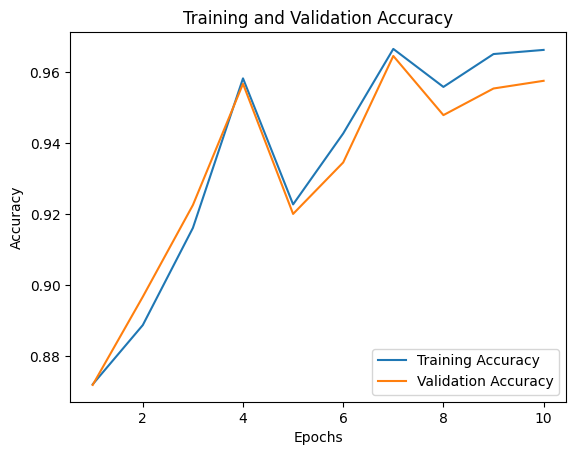

In [10]:
##################################################
#Training with weight regularization
##################################################
def training_with_weight_regularization(inputs, targets, l2_reg_lambda=0.01, batch_size=128, epochs=10, train_val_split=0.9, learning_rate=0.001):
    train_accuracy_history = []
    val_accuracy_history = []

    Inputs = np.zeros((len(inputs), inputs.shape[1]**2))
    for i in range(len(inputs)):
        Inputs[i] = inputs[i].flatten()

    hidden_units = 512
    n_classes = 10
    n_samples = Inputs.shape[0]
    n_batches = n_samples // batch_size

    split_index = int(train_val_split * len(Inputs))
    train_inputs, train_targets = Inputs[:split_index], targets[:split_index]
    val_inputs, val_targets = Inputs[split_index:], targets[split_index:]

    input_size = Inputs.shape[1]
    W1 = np.random.randn(hidden_units, input_size) * 0.01
    W2 = np.random.randn(hidden_units, hidden_units) * 0.01
    W3 = np.random.randn(n_classes, hidden_units) * 0.01
    weights = [W1, W2, W3]

    m = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]
    v = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]

    for epoch in range(epochs):
        shuffle_index = np.random.permutation(split_index)
        train_inputs_shuffled = train_inputs[shuffle_index]
        train_targets_shuffled = train_targets[shuffle_index]

        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            batch_inputs = train_inputs_shuffled[start:end]
            batch_targets = train_targets_shuffled[start:end]

            activations = fwdPropagate(batch_inputs, weights)
            gradients = computeGradients(batch_inputs, batch_targets, weights, activations, l2_reg_lambda=l2_reg_lambda)

            t = epoch * n_batches + batch + 1
            weights, m, v = adam_optimizer(weights, gradients, m, v, t, learning_rate=learning_rate)

        train_activations = fwdPropagate(train_inputs, weights)
        train_output = train_activations[-1]
        train_predictions = np.argmax(train_output, axis=1)
        train_accuracy = np.mean(train_predictions == np.argmax(train_targets, axis=1))
        train_error = 1 - train_accuracy

        val_activations = fwdPropagate(val_inputs, weights)
        val_output = val_activations[-1]
        val_predictions = np.argmax(val_output, axis=1)
        val_accuracy = np.mean(val_predictions == np.argmax(val_targets, axis=1))
        val_error = 1 - val_accuracy

        print(f"Epoch {epoch + 1}/{epochs}, Train Error: {train_error:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Error: {val_error:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)

    plot_training_history(train_accuracy_history, val_accuracy_history)

    return train_accuracy, val_accuracy

targets = np.zeros((len(mnist_trainlabel), 10))
for i in range(0, len(mnist_trainlabel)):
    targets[i][int(mnist_trainlabel[i])] = 1

# Call the training function with weight regularization
print("1.Training function with weight regularization :\n")
train_accuracy_weight_reg, val_accuracy_weight_reg = training_with_weight_regularization(mnist_traindata, targets, l2_reg_lambda=0.01)

2.Training function with dropout :

Epoch 1/10, Train Error: 0.7045, Train Accuracy: 0.2955, Validation Error: 0.6967, Validation Accuracy: 0.3033
Epoch 2/10, Train Error: 0.8065, Train Accuracy: 0.1935, Validation Error: 0.8043, Validation Accuracy: 0.1957
Epoch 3/10, Train Error: 0.7560, Train Accuracy: 0.2440, Validation Error: 0.7430, Validation Accuracy: 0.2570
Epoch 4/10, Train Error: 0.6681, Train Accuracy: 0.3319, Validation Error: 0.6572, Validation Accuracy: 0.3428
Epoch 5/10, Train Error: 0.7337, Train Accuracy: 0.2663, Validation Error: 0.7098, Validation Accuracy: 0.2902
Epoch 6/10, Train Error: 0.7069, Train Accuracy: 0.2931, Validation Error: 0.6940, Validation Accuracy: 0.3060
Epoch 7/10, Train Error: 0.6301, Train Accuracy: 0.3699, Validation Error: 0.6203, Validation Accuracy: 0.3797
Epoch 8/10, Train Error: 0.6560, Train Accuracy: 0.3440, Validation Error: 0.6500, Validation Accuracy: 0.3500
Epoch 9/10, Train Error: 0.6975, Train Accuracy: 0.3025, Validation Error: 0

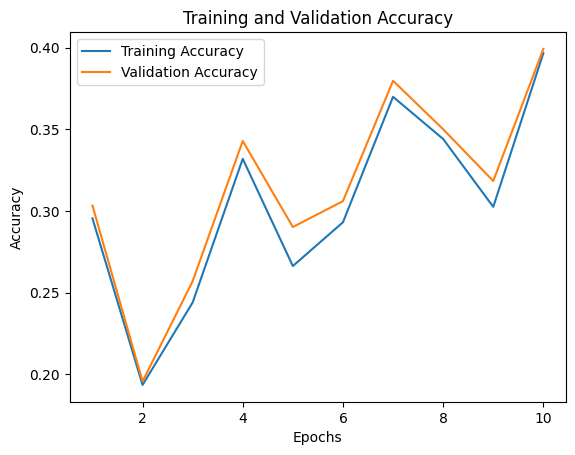

In [11]:
##################################################
#Training with dropout strategy
##################################################
def training_with_dropout(inputs, targets, dropout_rate=0.2, batch_size=128, epochs=10, train_val_split=0.9, learning_rate=0.001):
    train_accuracy_history = []
    val_accuracy_history = []

    Inputs = np.zeros((len(inputs), inputs.shape[1]**2))
    for i in range(len(inputs)):
        Inputs[i] = inputs[i].flatten()

    hidden_units = 512
    n_classes = 10
    n_samples = Inputs.shape[0]
    n_batches = n_samples // batch_size

    split_index = int(train_val_split * len(Inputs))
    train_inputs, train_targets = Inputs[:split_index], targets[:split_index]
    val_inputs, val_targets = Inputs[split_index:], targets[split_index:]

    input_size = Inputs.shape[1]
    W1 = np.random.randn(hidden_units, input_size) * 0.01
    W2 = np.random.randn(hidden_units, hidden_units) * 0.01
    W3 = np.random.randn(n_classes, hidden_units) * 0.01
    weights = [W1, W2, W3]

    m = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]
    v = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]

    for epoch in range(epochs):
        shuffle_index = np.random.permutation(split_index)
        train_inputs_shuffled = train_inputs[shuffle_index]
        train_targets_shuffled = train_targets[shuffle_index]

        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            batch_inputs = train_inputs_shuffled[start:end]
            batch_targets = train_targets_shuffled[start:end]

            activations = fwdPropagate(batch_inputs, weights, dropout_rate=dropout_rate)
            gradients = computeGradients(batch_inputs, batch_targets, weights, activations)

            t = epoch * n_batches + batch + 1
            weights, m, v = adam_optimizer(weights, gradients, m, v, t, learning_rate=learning_rate)

        train_activations = fwdPropagate(train_inputs, weights)
        train_output = train_activations[-1]
        train_predictions = np.argmax(train_output, axis=1)
        train_accuracy = np.mean(train_predictions == np.argmax(train_targets, axis=1))
        train_error = 1 - train_accuracy

        val_activations = fwdPropagate(val_inputs, weights)
        val_output = val_activations[-1]
        val_predictions = np.argmax(val_output, axis=1)
        val_accuracy = np.mean(val_predictions == np.argmax(val_targets, axis=1))
        val_error = 1 - val_accuracy

        print(f"Epoch {epoch + 1}/{epochs}, Train Error: {train_error:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Error: {val_error:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)

    plot_training_history(train_accuracy_history, val_accuracy_history)

    return train_accuracy, val_accuracy


targets = np.zeros((len(mnist_trainlabel), 10))
for i in range(0, len(mnist_trainlabel)):
    targets[i][int(mnist_trainlabel[i])] = 1

# Call the training function with dropout
print("2.Training function with dropout :\n")
train_accuracy_dropout, val_accuracy_dropout = training_with_dropout(mnist_traindata, targets, dropout_rate=0.2)

3.Training function with early stopping :

Epoch 1/10, Train Error: 0.1434, Train Accuracy: 0.8566, Validation Error: 0.1348, Validation Accuracy: 0.8652
Epoch 2/10, Train Error: 0.1103, Train Accuracy: 0.8897, Validation Error: 0.1148, Validation Accuracy: 0.8852
Epoch 3/10, Train Error: 0.0786, Train Accuracy: 0.9214, Validation Error: 0.0848, Validation Accuracy: 0.9152
Epoch 4/10, Train Error: 0.0336, Train Accuracy: 0.9664, Validation Error: 0.0377, Validation Accuracy: 0.9623
Epoch 5/10, Train Error: 0.0877, Train Accuracy: 0.9123, Validation Error: 0.0875, Validation Accuracy: 0.9125
Epoch 6/10, Train Error: 0.0658, Train Accuracy: 0.9342, Validation Error: 0.0713, Validation Accuracy: 0.9287
Epoch 7/10, Train Error: 0.0349, Train Accuracy: 0.9651, Validation Error: 0.0422, Validation Accuracy: 0.9578
Early stopping...


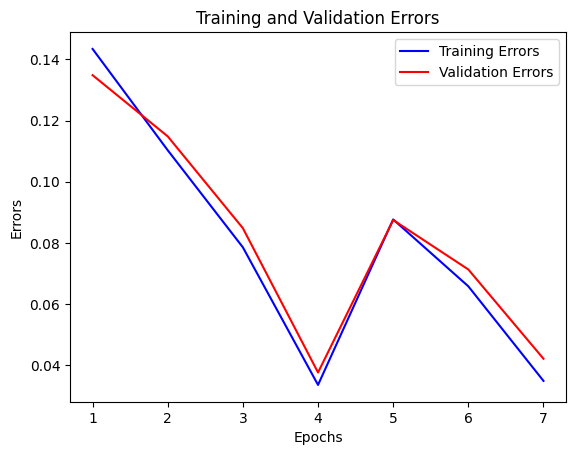

In [12]:
##################################################
#Training with early stopping criterion
##################################################

def plot_training_history(train_errors_history, val_errors_history):
    epochs = range(1, len(train_errors_history) + 1)
    plt.plot(epochs, train_errors_history, 'b', label='Training Errors')
    plt.plot(epochs, val_errors_history, 'r', label='Validation Errors')
    plt.title('Training and Validation Errors')
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.legend()
    plt.show()

def training_with_early_stopping(inputs, targets, batch_size=128, epochs=10, train_val_split=0.9, learning_rate=0.001, early_stopping_patience=3):
    train_accuracy_history = []
    val_accuracy_history = []
    train_error_history = [] 
    val_error_history = []

    Inputs = np.zeros((len(inputs), inputs.shape[1]**2))
    for i in range(len(inputs)):
        Inputs[i] = inputs[i].flatten()

    hidden_units = 512
    n_classes = 10
    n_samples = Inputs.shape[0]
    n_batches = n_samples // batch_size

    split_index = int(train_val_split * len(Inputs))
    train_inputs, train_targets = Inputs[:split_index], targets[:split_index]
    val_inputs, val_targets = Inputs[split_index:], targets[split_index:]

    input_size = Inputs.shape[1]
    W1 = np.random.randn(hidden_units, input_size) * 0.01
    W2 = np.random.randn(hidden_units, hidden_units) * 0.01
    W3 = np.random.randn(n_classes, hidden_units) * 0.01
    weights = [W1, W2, W3]

    m = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]
    v = [np.zeros_like(W1), np.zeros_like(W2), np.zeros_like(W3)]

    best_val_accuracy = 0
    patience_counter = 0
    early_stopping_epoch = 0

    for epoch in range(epochs):
        shuffle_index = np.random.permutation(split_index)
        train_inputs_shuffled = train_inputs[shuffle_index]
        train_targets_shuffled = train_targets[shuffle_index]

        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            batch_inputs = train_inputs_shuffled[start:end]
            batch_targets = train_targets_shuffled[start:end]

            activations = fwdPropagate(batch_inputs, weights)
            gradients = computeGradients(batch_inputs, batch_targets, weights, activations)

            t = epoch * n_batches + batch + 1
            weights, m, v = adam_optimizer(weights, gradients, m, v, t, learning_rate=learning_rate)

        train_activations = fwdPropagate(train_inputs, weights)
        train_output = train_activations[-1]
        train_predictions = np.argmax(train_output, axis=1)
        train_accuracy = np.mean(train_predictions == np.argmax(train_targets, axis=1))
        train_error = 1 - train_accuracy

        val_activations = fwdPropagate(val_inputs, weights)
        val_output = val_activations[-1]
        val_predictions = np.argmax(val_output, axis=1)
        val_accuracy = np.mean(val_predictions == np.argmax(val_targets, axis=1))
        val_error = 1 - val_accuracy

        print(f"Epoch {epoch + 1}/{epochs}, Train Error: {train_error:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Error: {val_error:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        train_error_history.append(train_error)  # Append errors to the history lists
        val_error_history.append(val_error)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping...")
                early_stopping_epoch = epoch - early_stopping_patience
                break

    plot_training_history(train_error_history, val_error_history) 

    return train_accuracy, val_accuracy, early_stopping_epoch


targets = np.zeros((len(mnist_trainlabel), 10))
for i in range(0, len(mnist_trainlabel)):
    targets[i][int(mnist_trainlabel[i])] = 1

# Call the training function with early stopping criterion
print("3.Training function with early stopping :\n")
train_accuracy, val_accuracy, early_stopping_epoch = training_with_early_stopping(mnist_traindata, targets, early_stopping_patience=3)

**Report your observations**
1. **Weight Regularization:**
   - Stable convergence with higher validation accuracy.
   - Effective regularization observed.

2. **Dropout:**
   - Poor performance, indicating underfitting.
   - Hindered learning process observed.

3. **Early Stopping:**
   - Efficient training with prevention of overfitting.
   - Competitive accuracies achieved with stable convergence.